<a href="https://colab.research.google.com/github/xuezhicang/NIUCSCI680/blob/master/csci680_xcang_assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [0]:
varName = ["fixed acidity","volatile acidity","citric acid","residual sugar",\
           "chlorides","free sulfur dioxide","total sulfur dioxide","density",\
           "pH","sulphates","alcohol","quality"]


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


#read training set
data_all = pd.read_csv('https://raw.githubusercontent.com/pratoolbharti/Applied_Machine_Learning_S20/master/Data-HW4/winequality-white.csv', sep=";")

print("original data")
print(data_all.head())
scaler = MinMaxScaler()
data_all[data_all.columns] = scaler.fit_transform(data_all[data_all.columns])

print("scaled data")
print(data_all.head())
data_X_all = data_all.drop(labels = "quality",axis=1)


# Y of training set
data_Y_all = data_all["quality"]


data_X, x_test, data_Y, y_test = train_test_split(data_X_all, data_Y_all, random_state=0)


#get the features' name
indepName = list(data_X.columns) 


original data
   fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.0              0.27         0.36  ...       0.45      8.8        6
1            6.3              0.30         0.34  ...       0.49      9.5        6
2            8.1              0.28         0.40  ...       0.44     10.1        6
3            7.2              0.23         0.32  ...       0.40      9.9        6
4            7.2              0.23         0.32  ...       0.40      9.9        6

[5 rows x 12 columns]
scaled data
   fixed acidity  volatile acidity  citric acid  ...  sulphates   alcohol  quality
0       0.307692          0.186275     0.216867  ...   0.267442  0.129032      0.5
1       0.240385          0.215686     0.204819  ...   0.313953  0.241935      0.5
2       0.413462          0.196078     0.240964  ...   0.255814  0.338710      0.5
3       0.326923          0.147059     0.192771  ...   0.209302  0.306452      0.5
4       0.326923          0.147059     0.192

#Question 1
Train a Random Forest Regressor for the dataset. Find the best model based on R-squared value using
RandomizedSearchCV. [10 Marks]

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score


In [0]:
model_1 = RandomForestRegressor()

#parameters 
param_grid_1 = {'n_estimators': np.array([15,50,100,200]),\
                'max_depth':np.array([10,20]),\
                'criterion':np.array(['mse',"mae"]),\
                'max_depth':np.array([4,6,10]),\
                'min_samples_split':np.array([100,200,300])} # for RFR regression

grid_RFR = RandomizedSearchCV(model_1,param_grid_1,cv =5,scoring="r2")


#train the model
print("model results")
grid_RFR.fit(data_X,data_Y)
print(grid_RFR.best_params_)
print("score for the training data")
print(grid_RFR.best_score_)


#applying the data to the test data
print("appling the model to the test data set")
y_estimated = grid_RFR.best_estimator_.predict(x_test)
r2_score(y_test,y_estimated)



{'n_estimators': 50, 'min_samples_split': 100, 'max_depth': 10, 'criterion': 'mse'}
0.36811266469823634
appling the model to the test data set


0.32181248405684837

##Question2 
Use the best model from question 1 for model interpretation and rank the features based on drop feature
importance. [15 Marks]

In [0]:
def drop_feature_importance(est, X, y):
    base_score = np.mean(cross_val_score(est, X, y))
    scores = []
    for feature in range(X.shape[1]):
        mask = np.ones(X.shape[1], 'bool')
        mask[feature] = False
        X_new = X.iloc[:, mask]
        this_score = np.mean(cross_val_score(est, X_new, y))
        scores.append(base_score - this_score)
    return np.array(scores)
    

In [0]:
#calculate the scores using the drop feature method
scores_drop_feature = drop_feature_importance(grid_RFR.best_estimator_, data_X, data_Y)



In [0]:
#sorting the scores
scores_drop_feature_and_indepname = {'variableName':indepName,'score_drop_feature':scores_drop_feature}
score_drop_feature_pd = pd.DataFrame(scores_drop_feature_and_indepname)

score_drop_feature_pd = score_drop_feature_pd.sort_values("score_drop_feature", ascending = False) 
score_drop_feature_pd['score_drop_feature_raking'] = score_drop_feature_pd['score_drop_feature'].rank(ascending  = False)
print(score_drop_feature_pd)

            variableName  score_drop_feature  score_drop_feature_raking
5    free sulfur dioxide            0.027606                        1.0
10               alcohol            0.025911                        2.0
1       volatile acidity            0.025057                        3.0
8                     pH            0.006208                        4.0
3         residual sugar            0.005184                        5.0
4              chlorides            0.003855                        6.0
6   total sulfur dioxide            0.003680                        7.0
0          fixed acidity            0.000094                        8.0
9              sulphates           -0.000855                        9.0
2            citric acid           -0.000925                       10.0
7                density           -0.001643                       11.0


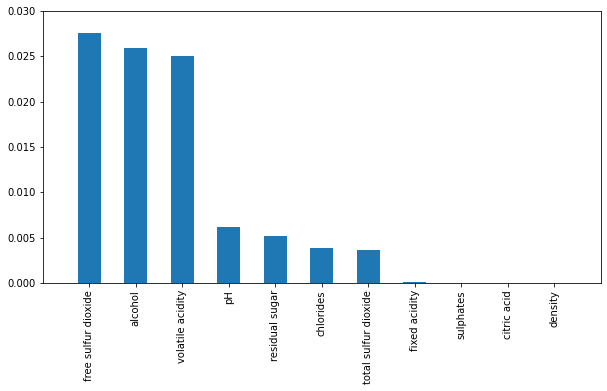

In [0]:
#ploting the scores
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.bar(np.arange(len(indepName)), score_drop_feature_pd['score_drop_feature'],width=0.5)
ax1.set_ylim(0,0.030)
ax1.set_xlim(-1,len(indepName))
ax1.xaxis.set_major_locator(plt.MultipleLocator(2))
plt.xticks(np.arange(len(indepName)), score_drop_feature_pd["variableName"],rotation='vertical')
plt.show()



## Question3
Use the best model from question 1 for model interpretation and rank the features based on permutation
importance. [15 Marks]

In [0]:
def permutation_importance(est, X, y, n_repeat=100):
    baseline_score = est.score(X, y)
    mean_scores = []
    for f_idx in range(X.shape[1]):
        scores = []    
        for repeat in range(n_repeat):
            X_new = X.copy()
            X_new[indepName[f_idx]] = np.random.permutation(X_new[ indepName[f_idx]].values)
            feature_score = est.score(X_new, y)
            scores.append(baseline_score - feature_score)
        scores = sum(scores)/len(scores)
        mean_scores.append(scores)
    return mean_scores

In [0]:
#calcualting the scores by using permutation importances methods
scores_dpermutation = permutation_importance(grid_RFR.best_estimator_, data_X, data_Y,10)



In [0]:
#sort the scores
scores_permutation_and_indepname = {'variableName':indepName,'score_permutation':scores_dpermutation}
score_permutation_pd = pd.DataFrame(scores_permutation_and_indepname)
score_permutation_pd = score_permutation_pd.sort_values("score_permutation", ascending = False) 
score_permutation_pd['score_permutation_ranking'] = score_permutation_pd['score_permutation'].rank(ascending  = False)

print(score_permutation_pd.head())

           variableName  score_permutation  score_permutation_ranking
10              alcohol           0.508312                        1.0
1      volatile acidity           0.188585                        2.0
5   free sulfur dioxide           0.103599                        3.0
8                    pH           0.039940                        4.0
3        residual sugar           0.029853                        5.0


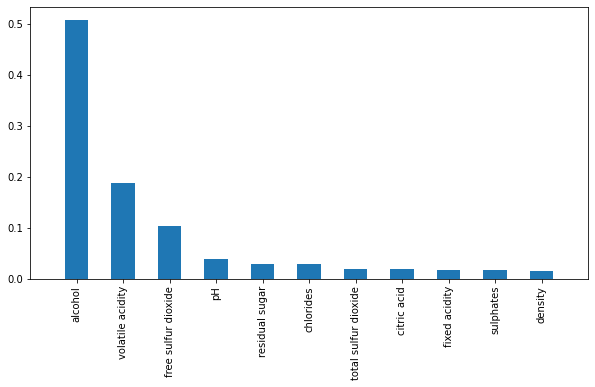

In [0]:
#ploting the scores
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))
plt.bar(np.arange(len(indepName)), score_permutation_pd['score_permutation'],width=0.5)
#ax1.set_ylim(0,1)
ax1.set_xlim(-1,len(indepName))
ax1.xaxis.set_major_locator(plt.MultipleLocator(2))
plt.xticks(np.arange(len(indepName)), score_permutation_pd["variableName"],rotation='vertical')
plt.show()

##Question4
Use the best model from question 1 for model interpretation and rank the features based on SHAP algorithm.
Install SHAP using pip. [20 Marks]

In [0]:
!pip install SHAP

     |████████████████████████████████| 276kB 1.4MB/s 
  Created wheel for SHAP: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394124 sha256=9449e9da0b2866358a29209f139b4ac8a52aee6c24a01cfb1b2aa5cdf51d4964
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built SHAP


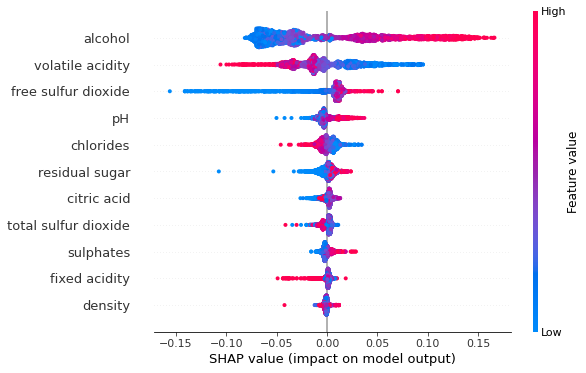

In [0]:
#calculate the SHAP values
import shap
shap.initjs()
model = grid_RFR.best_estimator_
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_X)

shap.summary_plot(shap_values, data_X)

In [0]:
#show the features contribution for the first sample
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], data_X.iloc[0,:])

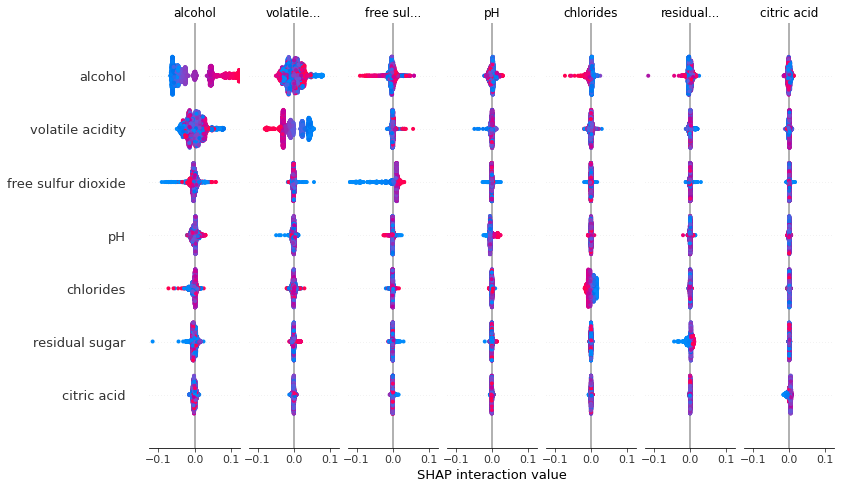

In [0]:
#show the interaction method. It can show whether the interacted variable could work better 
shap_interaction_values = explainer.shap_interaction_values(data_X)
shap.summary_plot(shap_interaction_values, data_X)

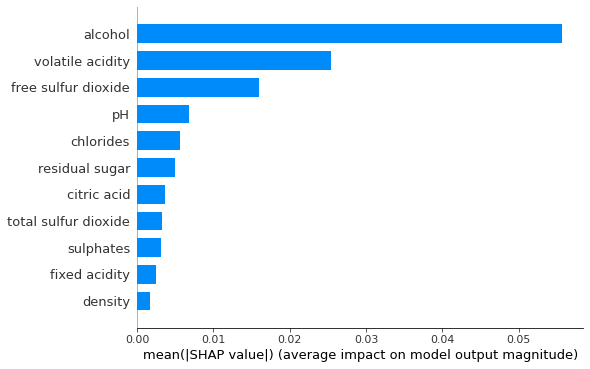

In [0]:
shap.summary_plot(shap_values, data_X, plot_type="bar")

##Question 5
Visualize partial dependence plot for each feature in the dataset using Sklearn. [10 Marks]

[]

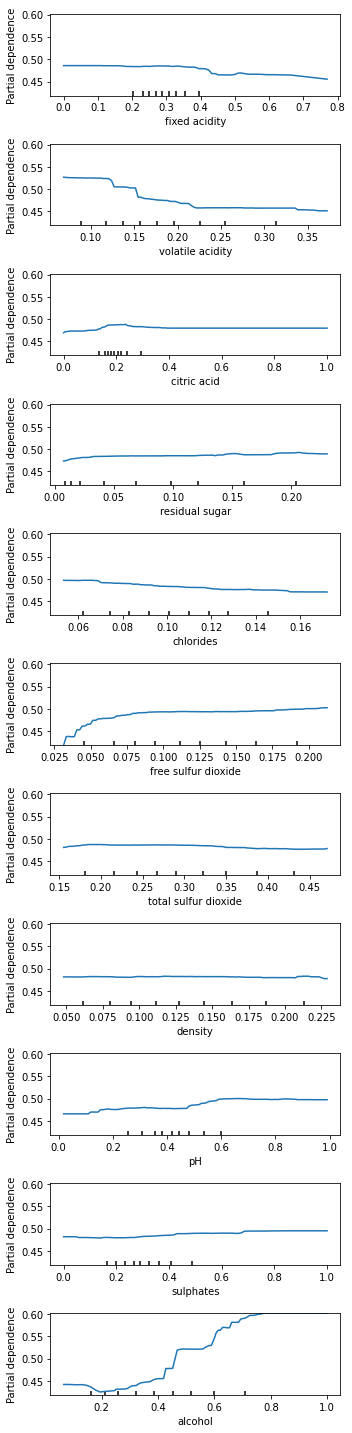

In [0]:
from sklearn.inspection import plot_partial_dependence

fig, axes = plt.subplots(11,figsize=(5,20))
plot_partial_dependence(grid_RFR.best_estimator_, data_X,indepName,ax=axes,n_jobs=2)
plt.tight_layout()
plt.plot()


#Question 6
Visualize ICE plot for each feature using following library. http://austinrochford.github.io/PyCEbox/
[20 Marks]

In [0]:
!pip install pycebox
from pycebox.ice import ice, ice_plot

  Created wheel for pycebox: filename=pycebox-0.0.1-cp36-none-any.whl size=3644 sha256=595619c16a45e8c636fa3203c45b3a08d1af3038835391ac075c1c2699e0aea2
  Stored in directory: /root/.cache/pip/wheels/58/5e/65/001126ca8b1f5c71e9571d09ba579e82bb0792062e7a82e77c
Successfully built pycebox


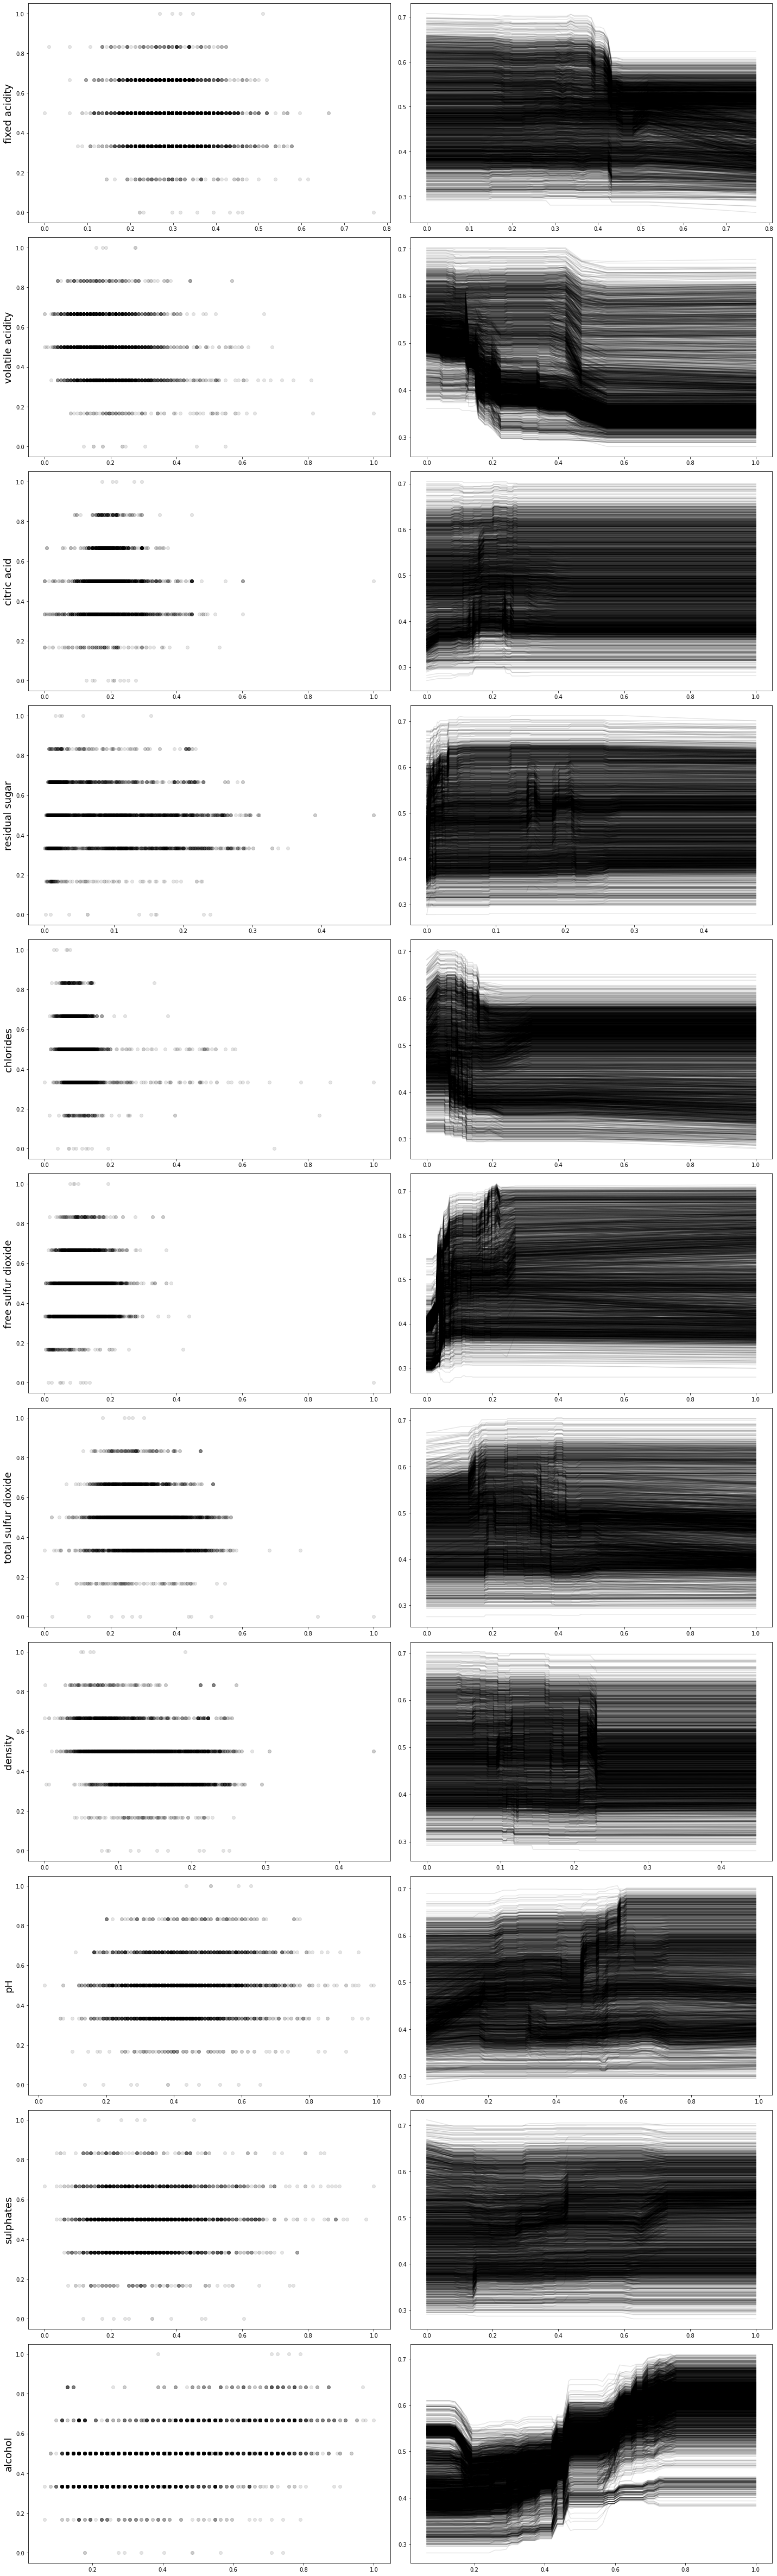

In [0]:
#plot the scatter(Y and each features)(left X is the feature Y is the quality) and ICEbox(right)
all_number =len(indepName)
fig, ice_ax = plt.subplots(all_number , 2,figsize=(20, all_number*6))
for i in range(all_number):
  ice_df = ice(data_X, indepName[i], grid_RFR.predict, num_grid_points=100)
  ice_ax[i][0].scatter(data_X[indepName[i]], data_Y, c='k', alpha=0.1);

  ice_plot(ice_df, frac_to_plot=1,c='k',  alpha=0.1,ax=ice_ax[i][1]);
  ice_ax[i][0].set_ylabel(indepName[i],fontsize=18)


plt.tight_layout()


## Question 7
Analyze outputs from each technique and comment that which technique you found most useful and why.
[10 Marks]


1. Dropping feature method.

Testing the importances by droping feature each time. My result shows that the most important features are 1)free sulfur dioxide 2) alcohol and 3)volatile acidity.


2. permutation importance

This method used the shuffed values to replaced the oringinal feature to test the importance of features. My result shows that the most important features are 1) alcohol 2)volatile acidity and free sulfur dioxide. The top three features are the same with the dropping feature method. The difference is that the alchol features are much more importnace than others. The inportance of these feature in dropping features are similar

3. SHAP values

The resutlts of this methods is very informative. It does not only tell the overall information, but also goes into the details of each samples. The x-axis of summary plot show the contributions(positive or negrive contribution) of the features's values. The color showed the intensity of the feature's value( large or small). Based on the summary, the corelation between the alchhol and qulity is stronger and clearer than other features.

The interaction plots shows that whetehr the interacted features could explained the Y bettwe. The plot do not uncover the enhancement.

The force plot(single sample) shows the contributions of each features for the estimated Y values.




4. Partial dependence plot

The partial dependence plot method fixs the other features' values and change the one feature's value to invesitigate how the Y changes with one feature.

If the curve is flat, it means that the features values within the flat range do not influence the Y value. For this reason, if the whole curve is flat, the feature is not important.

From this graphs, the Y change with the alcohol values. It shows that the importance of alcholi is very high.The density feature is very flat, so its importance is very low. The other methods also support these results. 


4.ICE plot

ICE plot is an enhanced version of partial dependence plot. Since the partial dependence plot only use the mean value of each values' contribution, it cannot show corelation if the corelations between indep and dep variables have two or more patterns. 

If all the lines are clustered together, the corelation is very high. If they are seperated totally.it means that the corelation is low beyween two variables. If two or more clustered areas are founded, the pattern which the Partial dpendence plot cannot detect is found.


I think that SHAP method is the most useful. The plots provided by SHAP donot only show the overall trends, but also provide the detail information for each samples. It also provided the information forthe interacted features. In these methods, the only thing that SHAP does not cover is the multi-pattern which can be detected by ICE plot. I suggest that we should used at least the SHAP and ICE plot to interpret the my model. 